## Training an RNN to do binary addition

In [1]:
from __future__ import print_function, division, absolute_import

In [2]:
import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Generating data

In [4]:
def generate_instance(bin_size=8, a=None, b=None):
    max_int = 2 ** bin_size - 1
    int2bin = lambda n: np.array([int(i) for i in np.binary_repr(n, bin_size)], dtype=np.int32)
    
    a = np.random.randint(0, max_int // 2) if a is None else a
    x1 = int2bin(a)
    
    b = np.random.randint(0, max_int // 2) if b is None else b
    x2 = int2bin(b)
    
    c = a + b
    y = int2bin(c)
    return x1,x2,y

In [5]:
def generate_batch(batch_size=100, bin_size=8):
    X = np.zeros(shape=[batch_size, bin_size, 2], dtype=np.int32)
    Y = np.zeros(shape=(batch_size, bin_size), dtype=np.int32)
    for i in range(batch_size):
        x1,x2,y = generate_instance(bin_size)
        X[i,:,0] = x1
        X[i,:,1] = x2
        Y[i,:] = y
    return X, Y

In [6]:
def ints2bins(ints, bin_size=8, concatenate=False):
    if concatenate:
        X = np.zeros([len(ints) ** 2, bin_size * 2])
    else:
        X = np.zeros([len(ints) ** 2, bin_size, 2])

    Y = np.zeros([len(ints) ** 2, bin_size])

    row_idx = 0
    for i, a in enumerate(ints):
        for j, b in enumerate(ints):

            x1, x2, y = generate_instance(bin_size, a, b)
            if concatenate:
                X[row_idx, :] = np.concatenate((x1, x2))
            else:
                X[row_idx, :, 0] = x1
                X[row_idx, :, 1] = x2
            Y[row_idx, :] = y
            row_idx += 1
    return X, Y

In [7]:
# This is if we want to make test instances that never appeared in the training set
def generate_train_test_set(bin_size=8, test_ratio=0.2, concatenate=False):
    max_int = 2 ** (bin_size-1)
    
    test_ints = np.random.choice(range(max_int), int(test_ratio*max_int), replace=False)
    train_ints = [i for i in range(max_int) if i not in test_ints]
    
    train_X, train_Y = ints2bins(train_ints, bin_size, concatenate)
    test_X, test_Y = ints2bins(test_ints, bin_size, concatenate)
    
    return train_X, train_Y, test_X, test_Y

### 100 integers are used for training
### The other 28 ones are used for testing

In [8]:
seed = 48
bin_size=8
hidden_size = 16

np.random.seed(seed)

In [9]:
train_X, train_Y, test_X, test_Y = generate_train_test_set(concatenate=True)
train_X.shape, train_Y.shape

((10609, 16), (10609, 8))

## First: Linear Regression
<img src="http://www.biostathandbook.com/pix/regressionlollipop.gif">

In [10]:
graph = tf.Graph()
with graph.as_default():
    train_x = tf.placeholder(tf.float32, [None, bin_size*2])
    train_y = tf.placeholder(tf.float32, [None, bin_size])
    
    theta = tf.Variable(
        tf.random_normal(shape=[bin_size*2, bin_size])
    )
    bias = tf.Variable(
        tf.zeros(shape=[bin_size])
    )
    
    pred = tf.add(tf.matmul(train_x,theta),bias)
    loss = tf.reduce_mean(tf.norm(train_y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(train_y, pred))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(mse)

In [11]:
def run_session(graph, loss_func="euclidean distance"):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        training = dict()
        testing = dict()
        training_mse = dict()
        testing_mse = dict()
        for j in range(20001):
            feed_dict = {train_x:train_X, train_y:train_Y}
            _, training_loss, training_mse_value = sess.run([optimizer, loss, mse], feed_dict=feed_dict)
            if j%10 == 0:
                training[j] = training_loss
                training_mse[j] = training_mse_value
                feed_dict = {train_x:test_X, train_y:test_Y}
                testing_loss = loss.eval(feed_dict=feed_dict)
                testing_mse_value = mse.eval(feed_dict=feed_dict)
                testing[j] = testing_loss
                testing_mse[j] = testing_mse_value
                if j%1000==0:
                    print(
                        """Epoch {0}\n
                        Train {5}: {1}\n
                        Train MSE: {2}\n
                        Test {5}: {3}\n
                        Test MSE: {4}""".format(
                        j,training_loss, training_mse_value, testing_loss, testing_mse_value, loss_func))
                    print("~"*40)
    return training, testing, training_mse, testing_mse

In [12]:
def plot_results(training, testing, training_mse, testing_mse, loss_func="Euclidean Distance"):
    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(training.keys())
    data1 = [training[i] for i in xticks]
    data2 = [testing[i] for i in xticks]
    data3 = [training_mse[i] for i in xticks]
    data4 = [testing_mse[i] for i in xticks]

    color1 = 'tab:blue'
    color2 = 'tab:green'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(loss_func)
    ax1.plot(xticks, data1, color=color1)
    ax1.plot(xticks, data2, color=color2)
    ax1.tick_params(axis='y')

    ax1.legend(["Train %s"%loss_func, "Test %s"%loss_func])

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color1 = 'tab:red'
    color2 = 'yellow'
    ax2.set_ylabel('MSE')
    ax2.plot(xticks, data3, color=color1)
    ax2.plot(xticks, data4, color=color2)
    ax2.tick_params(axis='y')
    ax2.legend(["Train MSE", "Test MSE"], loc=9)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [13]:
training, testing, training_mse, testing_mse = run_session(graph)

Epoch 0

                        Train euclidean distance: 725.9464721679688

                        Train MSE: 6.2093305587768555

                        Test euclidean distance: 195.83871459960938

                        Test MSE: 7.670560836791992
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train euclidean distance: 324.226806640625

                        Train MSE: 1.238606572151184

                        Test euclidean distance: 85.97323608398438

                        Test MSE: 1.4782793521881104
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train euclidean distance: 213.50303649902344

                        Train MSE: 0.5370858311653137

                        Test euclidean distance: 56.21881866455078

                        Test MSE: 0.632111132144928
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train euclidean distance: 166.26992797851562

                        Train

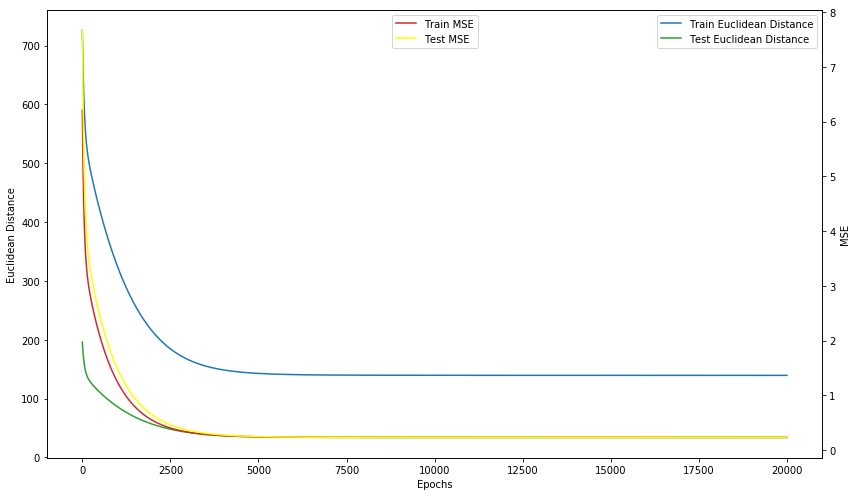

In [14]:
plot_results(training, testing, training_mse, testing_mse)

## Second: Single-Layer Perceptron
<a href="http://www.saedsayad.com/artificial_neural_network_bkp.htm">
    Dr. Saed Sayad: Artificial Neural Network - Perceptron
   <img src="http://www.saedsayad.com/images/Perceptron_bkp_1.png">
    </a>

In [15]:
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(seed)
    train_x = tf.placeholder(tf.float32, shape=[None,bin_size*2])
    train_y = tf.placeholder(tf.float32, shape=[None, bin_size])
    
    w = tf.Variable(tf.random_normal(shape=[bin_size*2, bin_size]))
    b = tf.Variable(tf.zeros(shape=[bin_size]))
    
    def model(data):
        return tf.add(tf.matmul(data,w),b)
    
    logits = model(train_x)
    pred = tf.nn.sigmoid(logits)
    loss = tf.reduce_mean(tf.abs(train_y-pred))
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=train_y, logits=logits))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(train_y, pred))
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [16]:
training, testing, training_mse, testing_mse = run_session(graph, "Abs Diff")

Epoch 0

                        Train Abs Diff: 0.49736639857292175

                        Train MSE: 0.3834434747695923

                        Test Abs Diff: 0.4772768020629883

                        Test MSE: 0.37703853845596313
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train Abs Diff: 0.4446355700492859

                        Train MSE: 0.3343033194541931

                        Test Abs Diff: 0.46935972571372986

                        Test MSE: 0.37499991059303284
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train Abs Diff: 0.39997777342796326

                        Train MSE: 0.3087638318538666

                        Test Abs Diff: 0.437576562166214

                        Test MSE: 0.36036622524261475
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train Abs Diff: 0.37432387471199036

                        Train MSE: 0.2978858947753906

                        Test A

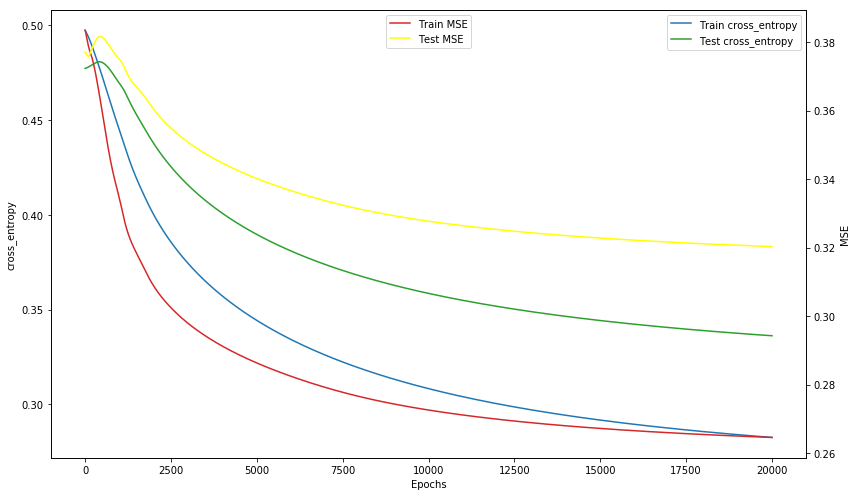

In [17]:
plot_results(training, testing, training_mse, testing_mse, "cross_entropy")

### Third: Feedforward NN (no recurrence yet)

In [18]:
graph_ff = tf.Graph()

with graph_ff.as_default():
    x1 = tf.placeholder(tf.float32, [None, bin_size])
    x2 = tf.placeholder(tf.float32, [None, bin_size])
    y = tf.placeholder(tf.float32, [None, bin_size])
    
    W1 = tf.Variable(tf.random_normal([bin_size, bin_size]))
    
    W2 = tf.Variable(tf.random_normal([bin_size, bin_size]))
    
    b = tf.Variable(tf.random_normal([bin_size]))
    
    predictions = tf.nn.sigmoid(tf.add(tf.add(tf.matmul(x1, W1), tf.matmul(x2, W2)), b))
    
    loss = tf.reduce_mean(tf.abs(y - predictions))
    
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, predictions))
    
    predictions_vals = tf.round(predictions)

In [19]:
train_X, train_Y, test_X, test_Y = generate_train_test_set()
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((10609, 8, 2), (10609, 8), (625, 8, 2), (625, 8))

In [20]:
test_X.shape[0] + train_X.shape[0]

11234

In [21]:
train_x1 = train_X[:,:,0]
train_x2 = train_X[:,:,1]

test_x1 = test_X[:,:,0]
test_x2 = test_X[:,:,1]

In [22]:
def run_session_rnn(graph, loss_func="Error",
                    dynamic=False, epochs=20001, p_every=1000, s_every=10, save=False):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        training = dict()
        testing = dict()
        training_mse = dict()
        testing_mse = dict()
        for j in range(epochs+1):
            feed_dict = {y: train_Y}
            if dynamic:
                feed_dict.update({X:train_X})
            else:
                feed_dict.update({x1:train_x1, x2:train_x2})
            _, training_loss, training_mse_value = sess.run([optimizer, loss, mse], feed_dict=feed_dict)
            if j%s_every == 0:
                training[j] = training_loss
                training_mse[j] = training_mse_value
                feed_dict = {y: test_Y}
                if dynamic:
                    feed_dict.update({X:test_X})
                else:
                    feed_dict.update({x1:test_x1, x2:test_x2})
                testing_loss = loss.eval(feed_dict=feed_dict)
                testing_mse_value = mse.eval(feed_dict=feed_dict)
                testing[j] = testing_loss
                testing_mse[j] = testing_mse_value
                if j%p_every==0:
                    print(
                        """Epoch {0}\n
                        Train {5}: {1}\n
                        Train MSE: {2}\n
                        Test {5}: {3}\n
                        Test MSE: {4}""".format(
                        j,training_loss, training_mse_value, testing_loss, testing_mse_value, loss_func))
                    print("~"*40)
        if save:
            saver = tf.train.Saver()
            saver.save(sess, "./binary_addition")
            return training, testing, training_mse, testing_mse, saver
    return training, testing, training_mse, testing_mse

In [23]:
training, testing, training_mse, testing_mse, saver_ff = run_session_rnn(graph_ff, save=True)

Epoch 0

                        Train Error: 0.5023019313812256

                        Train MSE: 0.3909919559955597

                        Test Error: 0.5049842596054077

                        Test MSE: 0.3926006257534027
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train Error: 0.3372914791107178

                        Train MSE: 0.30193790793418884

                        Test Error: 0.3515150845050812

                        Test MSE: 0.3137993812561035
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train Error: 0.31941795349121094

                        Train MSE: 0.2971242368221283

                        Test Error: 0.3336389362812042

                        Test MSE: 0.30888065695762634
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train Error: 0.31152427196502686

                        Train MSE: 0.29509270191192627

                        Test Error: 0.32552260160446

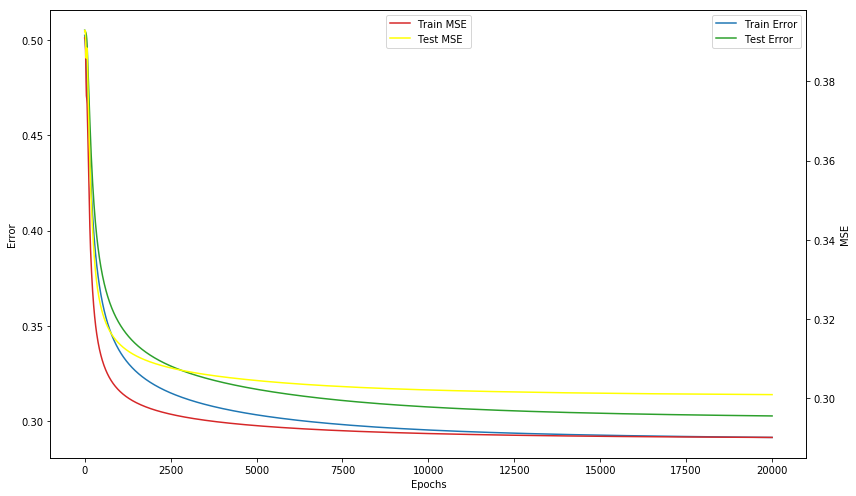

In [24]:
plot_results(training, testing, training_mse, testing_mse, "Error")

In [25]:
with tf.Session(graph=graph_ff) as sess:
    saver_ff.restore(sess, "./binary_addition")
    for i in range(10):
        x1_ = test_X[i].transpose()[0]
        x2_ = test_X[i].transpose()[1]
        ps = sess.run([predictions_vals],feed_dict={x1:[x1_], x2:[x2_]})
        ps = np.reshape(ps, (-1))
        
        rounded = np.round(ps)
        instance = np.transpose(test_X[i])
        instance_x1 = instance[0]
        instance_x2 = instance[1]
        instance_y = test_Y[i]
        bin2int = lambda x: sum([2**i*n for i,n in enumerate(np.flip(x,0))])
        
        a = bin2int(instance_x1)
        b = bin2int(instance_x2)
        c = bin2int(instance_y)
        d = bin2int(rounded)
        print(a, instance_x1)
        print(b, instance_x2)
        print(c, instance_y)
        print("Predicted\n{0} {1}".format(d, rounded))
        print("~"*10)

INFO:tensorflow:Restoring parameters from ./binary_addition
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
208.0 [1. 1. 0. 1. 0. 0. 0. 0.]
Predicted
150.0 [1. 0. 0. 1. 0. 1. 1. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
112.0 [0. 1. 1. 1. 0. 0. 0. 0.]
216.0 [1. 1. 0. 1. 1. 0. 0. 0.]
Predicted
134.0 [1. 0. 0. 0. 0. 1. 1. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
80.0 [0. 1. 0. 1. 0. 0. 0. 0.]
184.0 [1. 0. 1. 1. 1. 0. 0. 0.]
Predicted
134.0 [1. 0. 0. 0. 0. 1. 1. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
53.0 [0. 0. 1. 1. 0. 1. 0. 1.]
157.0 [1. 0. 0. 1. 1. 1. 0. 1.]
Predicted
142.0 [1. 0. 0. 0. 1. 1. 1. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
62.0 [0. 0. 1. 1. 1. 1. 1. 0.]
166.0 [1. 0. 1. 0. 0. 1. 1. 0.]
Predicted
134.0 [1. 0. 0. 0. 0. 1. 1. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
37.0 [0. 0. 1. 0. 0. 1. 0. 1.]
141.0 [1. 0. 0. 0. 1. 1. 0. 1.]
Predicted
142.0 [1. 0. 0. 0. 1. 1. 1. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
31.0 [0. 0. 0. 1. 

## Now let's try RNN
<a href="http://peterroelants.github.io/posts/rnn_implementation_part02/">
    Peter's notes: How to implement a recurrent neural network
<img src="https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_1.png"></a>

In [26]:
n_inputs = 2
n_outputs = 1
h_size = 16

In [27]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [47]:
graph_rnn = tf.Graph()
with graph_rnn.as_default():
    X = tf.placeholder(tf.float32, [None, bin_size, n_inputs])  # num of instances, num of time steps, input size
    y = tf.placeholder(tf.float32, [None, bin_size])
    #     X = tf.placeholder(tf.float32, [bin_size, n_inputs])  # num of time steps, input size
    #     y = tf.placeholder(tf.float32, [bin_size])

    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=h_size, activation=tf.nn.sigmoid)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
    # outputs n number of instances x 8 time steps x 32 neurons
    stacked_rnn_outputs = tf.reshape(outputs, [-1, h_size])
    stacked_outputs = tf.contrib.layers.fully_connected(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, bin_size])
    
    loss = tf.reduce_mean(tf.abs(y-outputs))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, outputs))
    optimizer = tf.train.AdamOptimizer(0.01).minimize(mse)
    

In [48]:
# train_X = np.flip(train_X, 1)
# train_Y = np.flip(train_Y, 1)

In [49]:
# test_X = np.flip(test_X, 1)
# test_Y = np.flip(test_Y, 1)

In [51]:
train_X, train_Y, test_X, test_Y = generate_train_test_set()

training, testing, training_mse, testing_mse, saver_rnn = run_session_rnn(
    graph_rnn, 'Abs Diff', dynamic=True,
    epochs=500, s_every=1, p_every=25, save=True)

Epoch 0

                        Train Abs Diff: 0.49868500232696533

                        Train MSE: 0.4099915623664856

                        Test Abs Diff: 0.502084493637085

                        Test MSE: 0.2892952561378479
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25

                        Train Abs Diff: 0.49919888377189636

                        Train MSE: 0.25365325808525085

                        Test Abs Diff: 0.5026662349700928

                        Test MSE: 0.2578616738319397
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50

                        Train Abs Diff: 0.4995933175086975

                        Train MSE: 0.2502948045730591

                        Test Abs Diff: 0.5014334917068481

                        Test MSE: 0.2520361840724945
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 75

                        Train Abs Diff: 0.49963152408599854

                        Train MSE: 0.24979467689990997

                        Test Abs Diff:

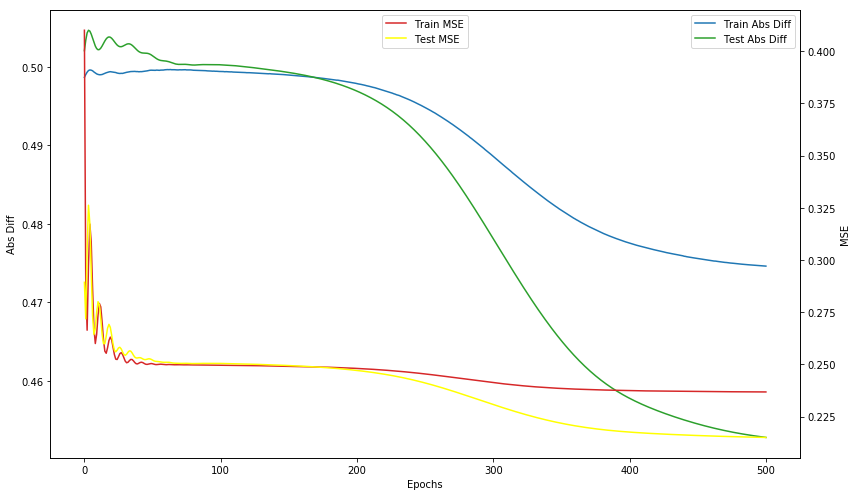

In [52]:
plot_results(training, testing, training_mse, testing_mse, "Abs Diff")

In [33]:
with tf.Session(graph=graph_rnn) as sess:
    saver_rnn.restore(sess, "./binary_addition")
    for i in range(10):
        ps = sess.run([outputs],feed_dict={X:test_X[i:i+1]})
        ps = np.array(ps).reshape(-1)
        rounded = np.round(ps)
        instance = np.transpose(test_X[i])
        instance_x1 = instance[0]
        instance_x2 = instance[1]
        instance_y = test_Y[i]
        bin2int = lambda x: sum([2**i*n for i,n in enumerate(np.flip(x,0))])
        
        a = bin2int(instance_x1)
        b = bin2int(instance_x2)
        c = bin2int(instance_y)
        d = bin2int(rounded)
        print(a, instance_x1)
        print(b, instance_x2)
        print(c, instance_y)
        print("Predicted\n{0} {1}".format(d, rounded))
        print("~"*10)

INFO:tensorflow:Restoring parameters from ./binary_addition
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
208.0 [1. 1. 0. 1. 0. 0. 0. 0.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
112.0 [0. 1. 1. 1. 0. 0. 0. 0.]
216.0 [1. 1. 0. 1. 1. 0. 0. 0.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
80.0 [0. 1. 0. 1. 0. 0. 0. 0.]
184.0 [1. 0. 1. 1. 1. 0. 0. 0.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
53.0 [0. 0. 1. 1. 0. 1. 0. 1.]
157.0 [1. 0. 0. 1. 1. 1. 0. 1.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
62.0 [0. 0. 1. 1. 1. 1. 1. 0.]
166.0 [1. 0. 1. 0. 0. 1. 1. 0.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
37.0 [0. 0. 1. 0. 0. 1. 0. 1.]
141.0 [1. 0. 0. 0. 1. 1. 0. 1.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
31.0 [0. 0. 0. 1. 1. 1. 1. 1.]

### Using ouputs as scalars instead of binary sequences

In [34]:
bin2int_vec = np.array([2**i for i in range(7,-1,-1)], dtype=np.float32)
train_Y_ints = np.dot(train_Y, bin2int_vec)
test_Y_ints = np.dot(test_Y, bin2int_vec)

In [35]:
train_Y = train_Y_ints
test_Y = test_Y_ints

In [36]:
reset_graph()
graph_rnn_ints = tf.Graph()
with graph_rnn_ints.as_default():
    X = tf.placeholder(tf.float32, [None, bin_size, n_inputs])  # num of instances, num of time steps, input size
    y = tf.placeholder(tf.float32, [None])

    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=h_size, activation=tf.nn.sigmoid)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
    # outputs n number of instances x 8 time steps x 32 neurons
    stacked_rnn_outputs = tf.reshape(outputs, [-1, h_size])
    stacked_outputs = tf.contrib.layers.fully_connected(stacked_rnn_outputs, n_outputs)
    binned_outputs = tf.reshape(stacked_outputs, [-1, bin_size])
    outputs = tf.reshape(tf.matmul(binned_outputs, tf.reshape(bin2int_vec, [bin_size,1])),[-1])
#     outputs = tf.reshape(tf.contrib.layers.fully_connected(states, 1),[-1])


    loss = tf.reduce_mean(tf.abs(y-outputs))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, outputs))
    optimizer = tf.train.RMSPropOptimizer(0.001).minimize(mse)


In [37]:
training, testing, training_mse, testing_mse, saver_rnn_inits = run_session_rnn(
    graph_rnn_ints, 'Abs Diff', dynamic=True,
    epochs=500, s_every=1, p_every=10, save=True)

Epoch 0

                        Train Abs Diff: 127.36247253417969

                        Train MSE: 19144.30078125

                        Test Abs Diff: 122.72705078125

                        Test MSE: 17072.654296875
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10

                        Train Abs Diff: 87.72142028808594

                        Train MSE: 10522.21484375

                        Test Abs Diff: 79.87010955810547

                        Test MSE: 8478.7607421875
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20

                        Train Abs Diff: 58.647621154785156

                        Train MSE: 5131.7080078125

                        Test Abs Diff: 48.53380584716797

                        Test MSE: 3580.59765625
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30

                        Train Abs Diff: 48.74848556518555

                        Train MSE: 3560.5078125

                        Test Abs Diff: 39.40414810180664

                   

Epoch 300

                        Train Abs Diff: 26.50913429260254

                        Train MSE: 1035.3609619140625

                        Test Abs Diff: 21.44512176513672

                        Test MSE: 684.4845581054688
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 310

                        Train Abs Diff: 25.586240768432617

                        Train MSE: 963.102294921875

                        Test Abs Diff: 20.680906295776367

                        Test MSE: 636.078125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 320

                        Train Abs Diff: 24.650964736938477

                        Train MSE: 892.5208740234375

                        Test Abs Diff: 19.90560531616211

                        Test MSE: 588.8235473632812
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 330

                        Train Abs Diff: 23.70401382446289

                        Train MSE: 823.7937622070312

                        Test Abs Diff: 19.1214427947998

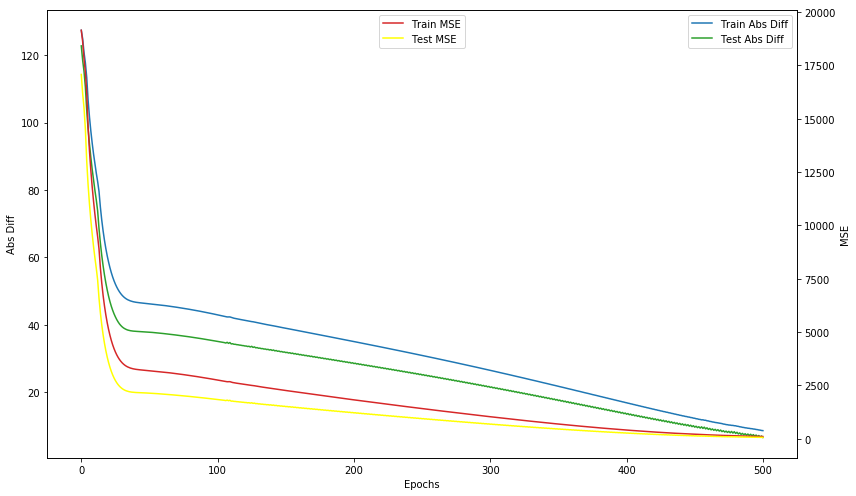

In [38]:
plot_results(training, testing, training_mse, testing_mse, "Abs Diff")

In [46]:
with tf.Session(graph=graph_rnn_ints) as sess:
    saver_rnn_inits.restore(sess, "./binary_addition")
    for i in range(10):
        ps = sess.run([outputs],feed_dict={X:test_X[i:i+1]})
        ps = np.array(ps).reshape(-1)
        rounded = np.round(ps)
        instance = np.transpose(test_X[i])
        instance_x1 = instance[0]
        instance_x2 = instance[1]
        c = test_Y[i]
        bin2int = lambda x: sum([2**i*n for i,n in enumerate(np.flip(x,0))])
        
        a = bin2int(instance_x1)
        b = bin2int(instance_x2)
        d = rounded
        print(a, instance_x1)
        print(b, instance_x2)
        print(c, np.binary_repr(int(c), 8))
        print("Predicted\n{0} {1}".format(d[0], np.binary_repr(int(rounded), 8)))
        print("~"*10)

INFO:tensorflow:Restoring parameters from ./binary_addition
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
208.0 11010000
Predicted
192.0 11000000
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
112.0 [0. 1. 1. 1. 0. 0. 0. 0.]
216.0 11011000
Predicted
199.0 11000111
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
80.0 [0. 1. 0. 1. 0. 0. 0. 0.]
184.0 10111000
Predicted
172.0 10101100
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
53.0 [0. 0. 1. 1. 0. 1. 0. 1.]
157.0 10011101
Predicted
147.0 10010011
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
62.0 [0. 0. 1. 1. 1. 1. 1. 0.]
166.0 10100110
Predicted
155.0 10011011
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
37.0 [0. 0. 1. 0. 0. 1. 0. 1.]
141.0 10001101
Predicted
132.0 10000100
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
31.0 [0. 0. 0. 1. 1. 1. 1. 1.]
135.0 10000111
Predicted
126.0 01111110
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0. 0.]
34.0 [0. 0. 1. 0. 0. 0. 1. 0.]
138.0 10001010
Predicted
129.0 10000001
~~~~~~~~~~
104.0 [0. 1. 1. 0. 1. 0. 0